In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : [],
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_e_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(663976, 919)
(663976, 1)
validation
(128936, 919)
(128936, 1)
test
(61376, 919)
(61376, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 919)]             0         


 dense (Dense)               (None, 1024)              942080    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1631233 (6.22 MB)


Trainable params: 1631233 (6.22 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/67 [..............................] - ETA: 1:29 - loss: 0.0124 - STD: 1.2049e-04 - MAE: 0.0924

 4/67 [>.............................] - ETA: 1s - loss: 0.0149 - STD: 3.1850e-04 - MAE: 0.0933  

 7/67 [==>...........................] - ETA: 1s - loss: 0.0143 - STD: 6.5966e-04 - MAE: 0.0945

10/67 [===>..........................] - ETA: 4s - loss: 0.0141 - STD: 8.6919e-04 - MAE: 0.0914

13/67 [====>.........................] - ETA: 3s - loss: 0.0135 - STD: 0.0012 - MAE: 0.0900    

16/67 [======>.......................] - ETA: 2s - loss: 0.0132 - STD: 0.0015 - MAE: 0.0902

19/67 [=======>......................] - ETA: 2s - loss: 0.0130 - STD: 0.0017 - MAE: 0.0889

22/67 [========>.....................] - ETA: 2s - loss: 0.0128 - STD: 0.0020 - MAE: 0.0879

25/67 [==========>...................] - ETA: 1s - loss: 0.0126 - STD: 0.0024 - MAE: 0.0876

28/67 [===========>..................] - ETA: 1s - loss: 0.0124 - STD: 0.0028 - MAE: 0.0871

30/67 [============>.................] - ETA: 1s - loss: 0.0123 - STD: 0.0031 - MAE: 0.0867

32/67 [=============>................] - ETA: 1s - loss: 0.0122 - STD: 0.0035 - MAE: 0.0862

34/67 [==============>...............] - ETA: 1s - loss: 0.0121 - STD: 0.0040 - MAE: 0.0860

37/67 [===============>..............] - ETA: 1s - loss: 0.0119 - STD: 0.0048 - MAE: 0.0857

40/67 [================>.............] - ETA: 0s - loss: 0.0118 - STD: 0.0058 - MAE: 0.0851

42/67 [=================>............] - ETA: 0s - loss: 0.0117 - STD: 0.0067 - MAE: 0.0847

44/67 [==================>...........] - ETA: 0s - loss: 0.0116 - STD: 0.0077 - MAE: 0.0844

46/67 [===================>..........] - ETA: 0s - loss: 0.0114 - STD: 0.0088 - MAE: 0.0841

48/67 [====================>.........] - ETA: 0s - loss: 0.0113 - STD: 0.0100 - MAE: 0.0837

50/67 [=====================>........] - ETA: 0s - loss: 0.0112 - STD: 0.0114 - MAE: 0.0833

52/67 [======================>.......] - ETA: 0s - loss: 0.0111 - STD: 0.0129 - MAE: 0.0830

54/67 [=======================>......] - ETA: 0s - loss: 0.0111 - STD: 0.0144 - MAE: 0.0826

56/67 [========================>.....] - ETA: 0s - loss: 0.0110 - STD: 0.0158 - MAE: 0.0823

58/67 [========================>.....] - ETA: 0s - loss: 0.0109 - STD: 0.0173 - MAE: 0.0820

60/67 [=========================>....] - ETA: 0s - loss: 0.0108 - STD: 0.0186 - MAE: 0.0817

62/67 [==========================>...] - ETA: 0s - loss: 0.0107 - STD: 0.0198 - MAE: 0.0814

64/67 [===========================>..] - ETA: 0s - loss: 0.0107 - STD: 0.0209 - MAE: 0.0811

66/67 [============================>.] - ETA: 0s - loss: 0.0106 - STD: 0.0219 - MAE: 0.0808

67/67 [==============================] - 4s 45ms/step - loss: 0.0106 - STD: 0.0223 - MAE: 0.0807 - val_loss: 0.0072 - val_STD: 0.0387 - val_MAE: 0.0666


Epoch 2/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0084 - STD: 0.0513 - MAE: 0.0714

 3/67 [>.............................] - ETA: 1s - loss: 0.0083 - STD: 0.0515 - MAE: 0.0718

 5/67 [=>............................] - ETA: 1s - loss: 0.0082 - STD: 0.0510 - MAE: 0.0712

 7/67 [==>...........................] - ETA: 1s - loss: 0.0082 - STD: 0.0508 - MAE: 0.0711

10/67 [===>..........................] - ETA: 1s - loss: 0.0082 - STD: 0.0513 - MAE: 0.0709

12/67 [====>.........................] - ETA: 1s - loss: 0.0081 - STD: 0.0516 - MAE: 0.0707

14/67 [=====>........................] - ETA: 1s - loss: 0.0080 - STD: 0.0522 - MAE: 0.0703

17/67 [======>.......................] - ETA: 1s - loss: 0.0080 - STD: 0.0530 - MAE: 0.0699

19/67 [=======>......................] - ETA: 1s - loss: 0.0079 - STD: 0.0535 - MAE: 0.0698

21/67 [========>.....................] - ETA: 1s - loss: 0.0079 - STD: 0.0541 - MAE: 0.0695

23/67 [=========>....................] - ETA: 1s - loss: 0.0078 - STD: 0.0546 - MAE: 0.0693

25/67 [==========>...................] - ETA: 1s - loss: 0.0078 - STD: 0.0550 - MAE: 0.0691

27/67 [===========>..................] - ETA: 1s - loss: 0.0077 - STD: 0.0553 - MAE: 0.0688

29/67 [===========>..................] - ETA: 0s - loss: 0.0077 - STD: 0.0557 - MAE: 0.0686

31/67 [============>.................] - ETA: 0s - loss: 0.0077 - STD: 0.0562 - MAE: 0.0684

33/67 [=============>................] - ETA: 0s - loss: 0.0076 - STD: 0.0568 - MAE: 0.0682

35/67 [==============>...............] - ETA: 0s - loss: 0.0076 - STD: 0.0572 - MAE: 0.0680

37/67 [===============>..............] - ETA: 0s - loss: 0.0076 - STD: 0.0576 - MAE: 0.0677

39/67 [================>.............] - ETA: 0s - loss: 0.0075 - STD: 0.0581 - MAE: 0.0675

41/67 [=================>............] - ETA: 0s - loss: 0.0075 - STD: 0.0586 - MAE: 0.0673

44/67 [==================>...........] - ETA: 0s - loss: 0.0074 - STD: 0.0592 - MAE: 0.0670

47/67 [====================>.........] - ETA: 0s - loss: 0.0074 - STD: 0.0598 - MAE: 0.0666

50/67 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.0603 - MAE: 0.0664

52/67 [======================>.......] - ETA: 0s - loss: 0.0073 - STD: 0.0606 - MAE: 0.0662

54/67 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.0609 - MAE: 0.0660

56/67 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.0612 - MAE: 0.0659

59/67 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.0616 - MAE: 0.0658

62/67 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.0618 - MAE: 0.0658

64/67 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.0617 - MAE: 0.0657

66/67 [============================>.] - ETA: 0s - loss: 0.0072 - STD: 0.0619 - MAE: 0.0657

67/67 [==============================] - 2s 31ms/step - loss: 0.0072 - STD: 0.0619 - MAE: 0.0657 - val_loss: 0.0058 - val_STD: 0.0486 - val_MAE: 0.0574


Epoch 3/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0062 - STD: 0.0616 - MAE: 0.0601

 4/67 [>.............................] - ETA: 1s - loss: 0.0067 - STD: 0.0636 - MAE: 0.0629

 7/67 [==>...........................] - ETA: 1s - loss: 0.0066 - STD: 0.0650 - MAE: 0.0629

10/67 [===>..........................] - ETA: 1s - loss: 0.0066 - STD: 0.0650 - MAE: 0.0625

13/67 [====>.........................] - ETA: 1s - loss: 0.0065 - STD: 0.0651 - MAE: 0.0621

16/67 [======>.......................] - ETA: 1s - loss: 0.0065 - STD: 0.0658 - MAE: 0.0619

19/67 [=======>......................] - ETA: 0s - loss: 0.0065 - STD: 0.0664 - MAE: 0.0618

22/67 [========>.....................] - ETA: 0s - loss: 0.0064 - STD: 0.0668 - MAE: 0.0616

25/67 [==========>...................] - ETA: 0s - loss: 0.0064 - STD: 0.0672 - MAE: 0.0614

28/67 [===========>..................] - ETA: 0s - loss: 0.0064 - STD: 0.0676 - MAE: 0.0612

32/67 [=============>................] - ETA: 0s - loss: 0.0064 - STD: 0.0681 - MAE: 0.0610

35/67 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0684 - MAE: 0.0609

38/67 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0687 - MAE: 0.0608

41/67 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0690 - MAE: 0.0607

44/67 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0693 - MAE: 0.0606

46/67 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0694 - MAE: 0.0605

49/67 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0695 - MAE: 0.0604

52/67 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0696 - MAE: 0.0603

55/67 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0698 - MAE: 0.0603

57/67 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0698 - MAE: 0.0602

59/67 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0700 - MAE: 0.0602

62/67 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0701 - MAE: 0.0601

65/67 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0702 - MAE: 0.0601

67/67 [==============================] - 2s 27ms/step - loss: 0.0062 - STD: 0.0702 - MAE: 0.0600 - val_loss: 0.0054 - val_STD: 0.0613 - val_MAE: 0.0561


Epoch 4/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0059 - STD: 0.0774 - MAE: 0.0600

 3/67 [>.............................] - ETA: 1s - loss: 0.0059 - STD: 0.0733 - MAE: 0.0586

 6/67 [=>............................] - ETA: 1s - loss: 0.0060 - STD: 0.0729 - MAE: 0.0588

 9/67 [===>..........................] - ETA: 1s - loss: 0.0060 - STD: 0.0729 - MAE: 0.0587

12/67 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0728 - MAE: 0.0586

15/67 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0729 - MAE: 0.0585

18/67 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0730 - MAE: 0.0585

21/67 [========>.....................] - ETA: 1s - loss: 0.0059 - STD: 0.0730 - MAE: 0.0585

24/67 [=========>....................] - ETA: 0s - loss: 0.0059 - STD: 0.0731 - MAE: 0.0585

27/67 [===========>..................] - ETA: 0s - loss: 0.0059 - STD: 0.0730 - MAE: 0.0584

30/67 [============>.................] - ETA: 0s - loss: 0.0059 - STD: 0.0728 - MAE: 0.0585

33/67 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0724 - MAE: 0.0587

36/67 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0720 - MAE: 0.0594

39/67 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0719 - MAE: 0.0597

42/67 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0716 - MAE: 0.0598

45/67 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0712 - MAE: 0.0597

48/67 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0708 - MAE: 0.0597

50/67 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0710 - MAE: 0.0597

53/67 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0708 - MAE: 0.0596

55/67 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0708 - MAE: 0.0596

58/67 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0709 - MAE: 0.0596

60/67 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0709 - MAE: 0.0594

62/67 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0711 - MAE: 0.0594

64/67 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0711 - MAE: 0.0593

66/67 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0713 - MAE: 0.0592

67/67 [==============================] - 2s 28ms/step - loss: 0.0061 - STD: 0.0713 - MAE: 0.0592 - val_loss: 0.0053 - val_STD: 0.0593 - val_MAE: 0.0533


Epoch 5/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0057 - STD: 0.0742 - MAE: 0.0567

 4/67 [>.............................] - ETA: 1s - loss: 0.0056 - STD: 0.0746 - MAE: 0.0564

 7/67 [==>...........................] - ETA: 1s - loss: 0.0056 - STD: 0.0744 - MAE: 0.0566

10/67 [===>..........................] - ETA: 1s - loss: 0.0056 - STD: 0.0747 - MAE: 0.0566

13/67 [====>.........................] - ETA: 1s - loss: 0.0055 - STD: 0.0752 - MAE: 0.0565

16/67 [======>.......................] - ETA: 1s - loss: 0.0056 - STD: 0.0755 - MAE: 0.0565

19/67 [=======>......................] - ETA: 1s - loss: 0.0055 - STD: 0.0755 - MAE: 0.0564

22/67 [========>.....................] - ETA: 0s - loss: 0.0055 - STD: 0.0756 - MAE: 0.0563

25/67 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0756 - MAE: 0.0563

28/67 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0758 - MAE: 0.0562

30/67 [============>.................] - ETA: 0s - loss: 0.0055 - STD: 0.0760 - MAE: 0.0562

32/67 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0759 - MAE: 0.0562

35/67 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0759 - MAE: 0.0562

38/67 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0759 - MAE: 0.0562

40/67 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0759 - MAE: 0.0562

43/67 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0759 - MAE: 0.0562

45/67 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0759 - MAE: 0.0563

47/67 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0758 - MAE: 0.0562

49/67 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0759 - MAE: 0.0562

52/67 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0758 - MAE: 0.0562

55/67 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0758 - MAE: 0.0562

57/67 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0759 - MAE: 0.0562

60/67 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0760 - MAE: 0.0561

63/67 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0760 - MAE: 0.0562

66/67 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0761 - MAE: 0.0563

67/67 [==============================] - 2s 27ms/step - loss: 0.0056 - STD: 0.0759 - MAE: 0.0563 - val_loss: 0.0058 - val_STD: 0.0579 - val_MAE: 0.0548


Epoch 6/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0708 - MAE: 0.0549

 3/67 [>.............................] - ETA: 1s - loss: 0.0075 - STD: 0.0738 - MAE: 0.0638

 5/67 [=>............................] - ETA: 1s - loss: 0.0074 - STD: 0.0731 - MAE: 0.0642

 8/67 [==>...........................] - ETA: 1s - loss: 0.0069 - STD: 0.0703 - MAE: 0.0619

11/67 [===>..........................] - ETA: 1s - loss: 0.0067 - STD: 0.0699 - MAE: 0.0615

13/67 [====>.........................] - ETA: 1s - loss: 0.0065 - STD: 0.0698 - MAE: 0.0610

15/67 [=====>........................] - ETA: 1s - loss: 0.0064 - STD: 0.0695 - MAE: 0.0606

17/67 [======>.......................] - ETA: 1s - loss: 0.0064 - STD: 0.0693 - MAE: 0.0603

19/67 [=======>......................] - ETA: 1s - loss: 0.0063 - STD: 0.0695 - MAE: 0.0600

21/67 [========>.....................] - ETA: 1s - loss: 0.0062 - STD: 0.0696 - MAE: 0.0597

23/67 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0700 - MAE: 0.0595

25/67 [==========>...................] - ETA: 1s - loss: 0.0061 - STD: 0.0702 - MAE: 0.0592

27/67 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0705 - MAE: 0.0590

29/67 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0708 - MAE: 0.0587

31/67 [============>.................] - ETA: 0s - loss: 0.0060 - STD: 0.0713 - MAE: 0.0585

33/67 [=============>................] - ETA: 0s - loss: 0.0059 - STD: 0.0715 - MAE: 0.0583

35/67 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0718 - MAE: 0.0581

37/67 [===============>..............] - ETA: 0s - loss: 0.0059 - STD: 0.0721 - MAE: 0.0580

39/67 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0723 - MAE: 0.0578

41/67 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0726 - MAE: 0.0576

43/67 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0728 - MAE: 0.0575

45/67 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0730 - MAE: 0.0574

47/67 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0732 - MAE: 0.0573

49/67 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0734 - MAE: 0.0572

51/67 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0736 - MAE: 0.0571

53/67 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0738 - MAE: 0.0570

55/67 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0740 - MAE: 0.0569

57/67 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0741 - MAE: 0.0569

60/67 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0743 - MAE: 0.0567

63/67 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0744 - MAE: 0.0566

65/67 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0746 - MAE: 0.0566

67/67 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0747 - MAE: 0.0565

67/67 [==============================] - 2s 31ms/step - loss: 0.0056 - STD: 0.0747 - MAE: 0.0565 - val_loss: 0.0058 - val_STD: 0.0635 - val_MAE: 0.0552


Epoch 7/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0777 - MAE: 0.0537

 3/67 [>.............................] - ETA: 1s - loss: 0.0051 - STD: 0.0793 - MAE: 0.0540

 5/67 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0791 - MAE: 0.0539

 7/67 [==>...........................] - ETA: 1s - loss: 0.0052 - STD: 0.0791 - MAE: 0.0540

 9/67 [===>..........................] - ETA: 1s - loss: 0.0051 - STD: 0.0791 - MAE: 0.0540

11/67 [===>..........................] - ETA: 1s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0540

13/67 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0540

15/67 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0540

17/67 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0785 - MAE: 0.0540

19/67 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0785 - MAE: 0.0540

22/67 [========>.....................] - ETA: 1s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0541

24/67 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0541

26/67 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0541

29/67 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0541

31/67 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0541

33/67 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0541

36/67 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0784 - MAE: 0.0542

39/67 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0542

42/67 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0542

44/67 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0542

46/67 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0542

48/67 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0541

51/67 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0541

54/67 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0540

56/67 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0541

58/67 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0540

60/67 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0786 - MAE: 0.0540

62/67 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0539

64/67 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0539

66/67 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0539

67/67 [==============================] - 2s 30ms/step - loss: 0.0051 - STD: 0.0787 - MAE: 0.0539 - val_loss: 0.0063 - val_STD: 0.0659 - val_MAE: 0.0580


Epoch 8/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0050 - STD: 0.0803 - MAE: 0.0530

 4/67 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0799 - MAE: 0.0535

 7/67 [==>...........................] - ETA: 1s - loss: 0.0052 - STD: 0.0787 - MAE: 0.0537

10/67 [===>..........................] - ETA: 1s - loss: 0.0052 - STD: 0.0791 - MAE: 0.0542

12/67 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0788 - MAE: 0.0540

14/67 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0785 - MAE: 0.0538

17/67 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0538

20/67 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0538

23/67 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0787 - MAE: 0.0538

26/67 [==========>...................] - ETA: 0s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0537

28/67 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0786 - MAE: 0.0537

31/67 [============>.................] - ETA: 0s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0536

34/67 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0538

36/67 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

38/67 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0790 - MAE: 0.0538

40/67 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

43/67 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0537

46/67 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0536

48/67 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0536

50/67 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0536

52/67 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0536

54/67 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0536

57/67 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

60/67 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537

63/67 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0537

65/67 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0788 - MAE: 0.0537

67/67 [==============================] - 2s 29ms/step - loss: 0.0051 - STD: 0.0789 - MAE: 0.0537 - val_loss: 0.0066 - val_STD: 0.0642 - val_MAE: 0.0600


Epoch 9/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0521

 4/67 [>.............................] - ETA: 1s - loss: 0.0049 - STD: 0.0783 - MAE: 0.0522

 6/67 [=>............................] - ETA: 1s - loss: 0.0049 - STD: 0.0788 - MAE: 0.0526

 8/67 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0788 - MAE: 0.0528

10/67 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0791 - MAE: 0.0527

13/67 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0788 - MAE: 0.0527

16/67 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0530

18/67 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0530

20/67 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0529

22/67 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0528

24/67 [=========>....................] - ETA: 0s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0527

27/67 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0527

30/67 [============>.................] - ETA: 0s - loss: 0.0049 - STD: 0.0796 - MAE: 0.0527

32/67 [=============>................] - ETA: 0s - loss: 0.0049 - STD: 0.0798 - MAE: 0.0528

35/67 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0794 - MAE: 0.0531

38/67 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0532

40/67 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0793 - MAE: 0.0532

43/67 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0532

46/67 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0532

49/67 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0533

52/67 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0533

55/67 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0532

58/67 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0532

61/67 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0789 - MAE: 0.0532

64/67 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0790 - MAE: 0.0531

67/67 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0791 - MAE: 0.0532

67/67 [==============================] - 2s 27ms/step - loss: 0.0050 - STD: 0.0791 - MAE: 0.0532 - val_loss: 0.0071 - val_STD: 0.0657 - val_MAE: 0.0628


Epoch 10/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0800 - MAE: 0.0522

 4/67 [>.............................] - ETA: 1s - loss: 0.0049 - STD: 0.0794 - MAE: 0.0523

 6/67 [=>............................] - ETA: 1s - loss: 0.0049 - STD: 0.0799 - MAE: 0.0526

 8/67 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0525

10/67 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0523

12/67 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0522

14/67 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0522

16/67 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0801 - MAE: 0.0522

18/67 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0802 - MAE: 0.0522

20/67 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0804 - MAE: 0.0522

22/67 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0807 - MAE: 0.0522

24/67 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0808 - MAE: 0.0526

26/67 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0804 - MAE: 0.0530

28/67 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0799 - MAE: 0.0535

30/67 [============>.................] - ETA: 0s - loss: 0.0051 - STD: 0.0802 - MAE: 0.0537

32/67 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0792 - MAE: 0.0540

34/67 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0786 - MAE: 0.0558

36/67 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0775 - MAE: 0.0567

38/67 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0769 - MAE: 0.0580

40/67 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0750 - MAE: 0.0590

42/67 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0747 - MAE: 0.0600

44/67 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0734 - MAE: 0.0602

46/67 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.0718 - MAE: 0.0605

49/67 [====================>.........] - ETA: 0s - loss: 0.0066 - STD: 0.0709 - MAE: 0.0612

52/67 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0693 - MAE: 0.0613

55/67 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0687 - MAE: 0.0615

57/67 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0686 - MAE: 0.0616

59/67 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0681 - MAE: 0.0616

61/67 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0681 - MAE: 0.0615

64/67 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0682 - MAE: 0.0615

67/67 [==============================] - ETA: 0s - loss: 0.0066 - STD: 0.0681 - MAE: 0.0613

67/67 [==============================] - 2s 31ms/step - loss: 0.0066 - STD: 0.0681 - MAE: 0.0613 - val_loss: 0.0053 - val_STD: 0.0580 - val_MAE: 0.0559


Epoch 11/10000


 1/67 [..............................] - ETA: 4s - loss: 0.0057 - STD: 0.0760 - MAE: 0.0596

 4/67 [>.............................] - ETA: 1s - loss: 0.0058 - STD: 0.0723 - MAE: 0.0586

 7/67 [==>...........................] - ETA: 1s - loss: 0.0056 - STD: 0.0717 - MAE: 0.0577

 9/67 [===>..........................] - ETA: 1s - loss: 0.0056 - STD: 0.0718 - MAE: 0.0574

11/67 [===>..........................] - ETA: 1s - loss: 0.0055 - STD: 0.0715 - MAE: 0.0569

13/67 [====>.........................] - ETA: 1s - loss: 0.0055 - STD: 0.0721 - MAE: 0.0569

15/67 [=====>........................] - ETA: 1s - loss: 0.0055 - STD: 0.0722 - MAE: 0.0567

17/67 [======>.......................] - ETA: 1s - loss: 0.0055 - STD: 0.0722 - MAE: 0.0564

19/67 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0728 - MAE: 0.0562

21/67 [========>.....................] - ETA: 1s - loss: 0.0054 - STD: 0.0730 - MAE: 0.0560

23/67 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0734 - MAE: 0.0557

25/67 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0737 - MAE: 0.0555

27/67 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0740 - MAE: 0.0554

30/67 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0552

33/67 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0551

36/67 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0549

38/67 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0548

40/67 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0547

43/67 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0757 - MAE: 0.0546

46/67 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0759 - MAE: 0.0544

48/67 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0761 - MAE: 0.0543

50/67 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0762 - MAE: 0.0543

53/67 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0765 - MAE: 0.0541

55/67 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0766 - MAE: 0.0541

57/67 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0767 - MAE: 0.0540

59/67 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0769 - MAE: 0.0539

61/67 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0769 - MAE: 0.0539

63/67 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0771 - MAE: 0.0538

65/67 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0772 - MAE: 0.0537

67/67 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0773 - MAE: 0.0537

67/67 [==============================] - 2s 30ms/step - loss: 0.0051 - STD: 0.0773 - MAE: 0.0537 - val_loss: 0.0069 - val_STD: 0.0663 - val_MAE: 0.0616


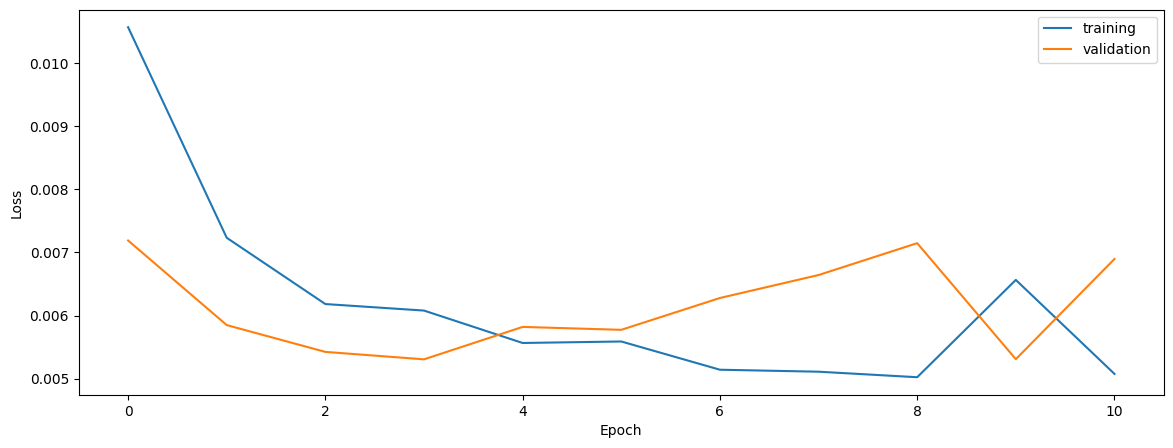

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7176649249639143
0.6971970156803744
0.653161430465561


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.7176649249639143
0.6971970156803744
0.653161430465561


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.7269518701696458
0.7127064617233554
0.6576918953575654


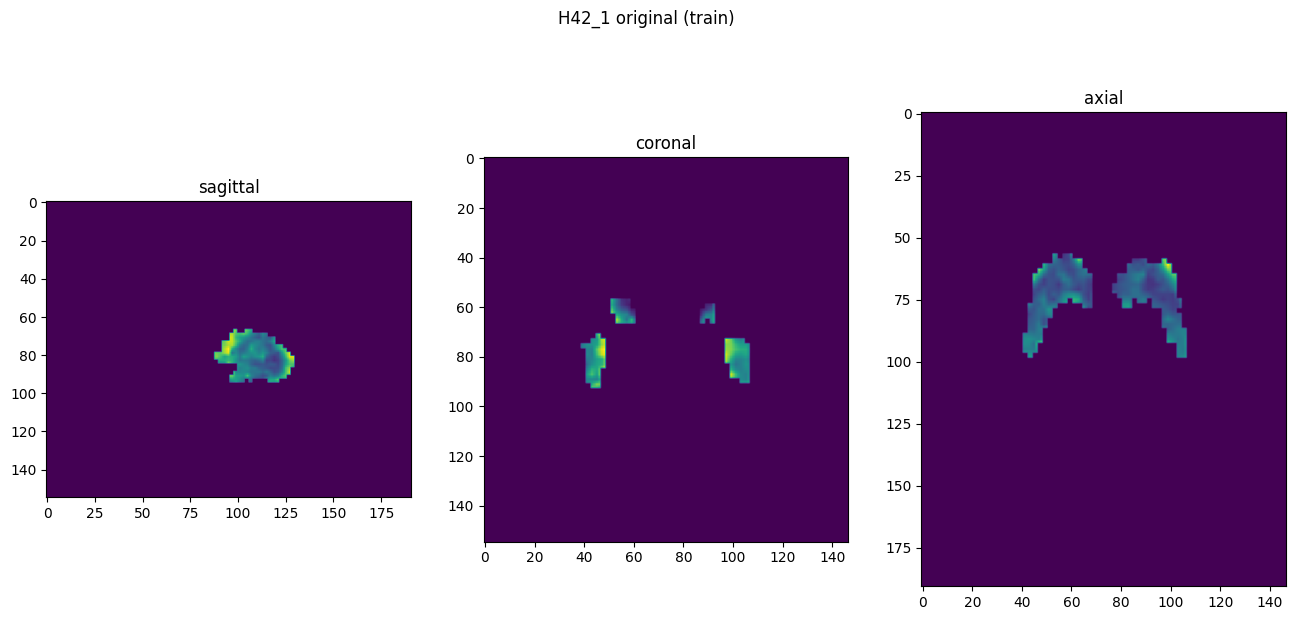

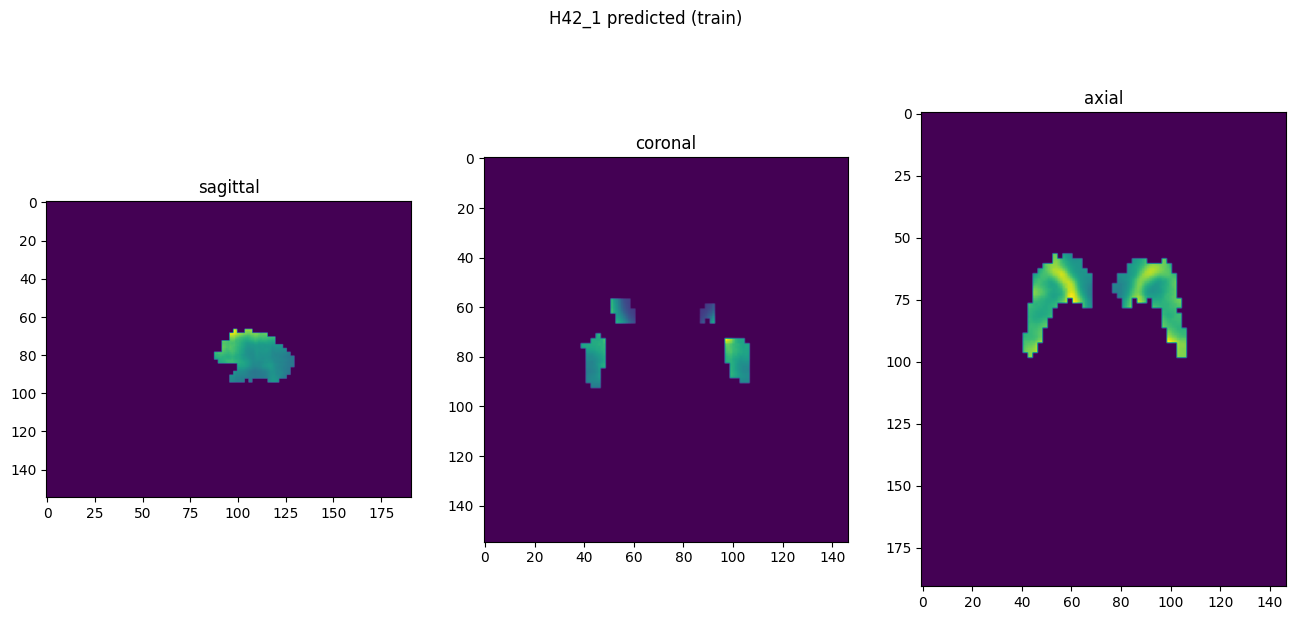

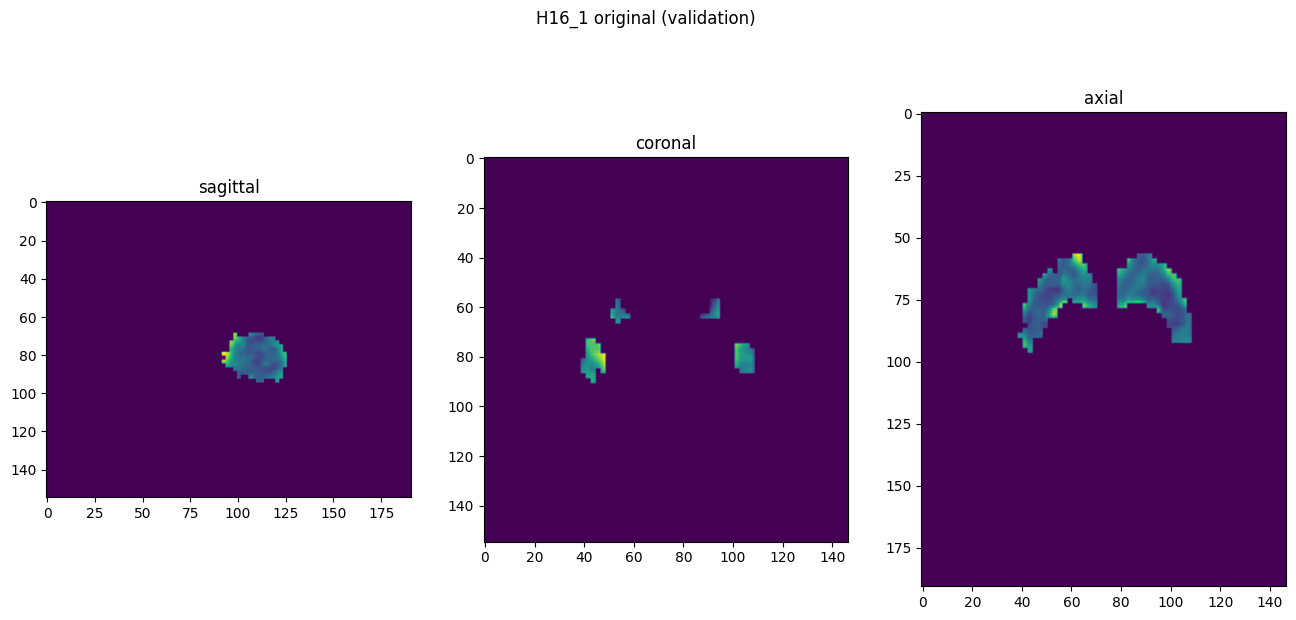

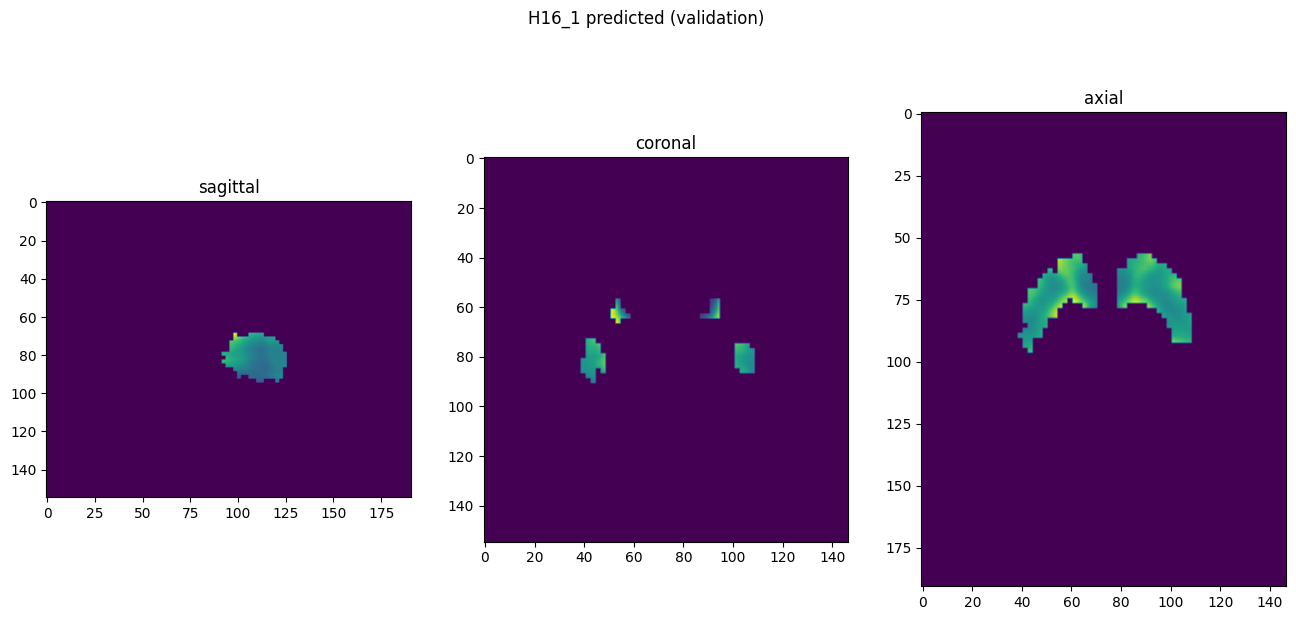

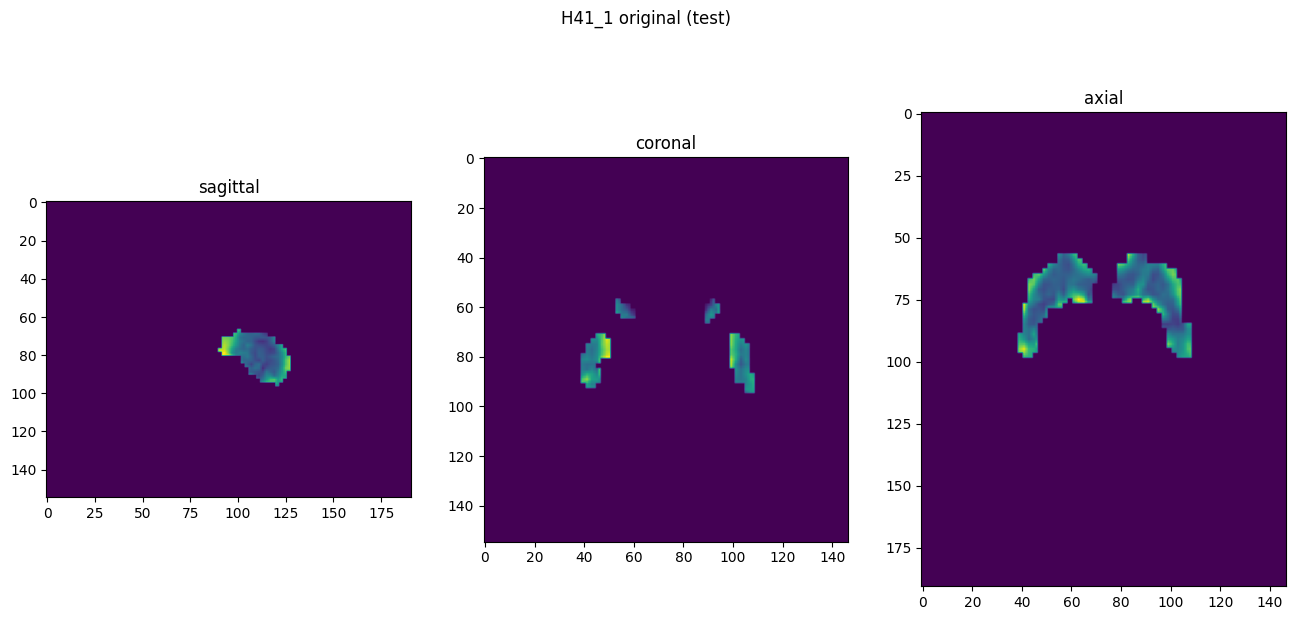

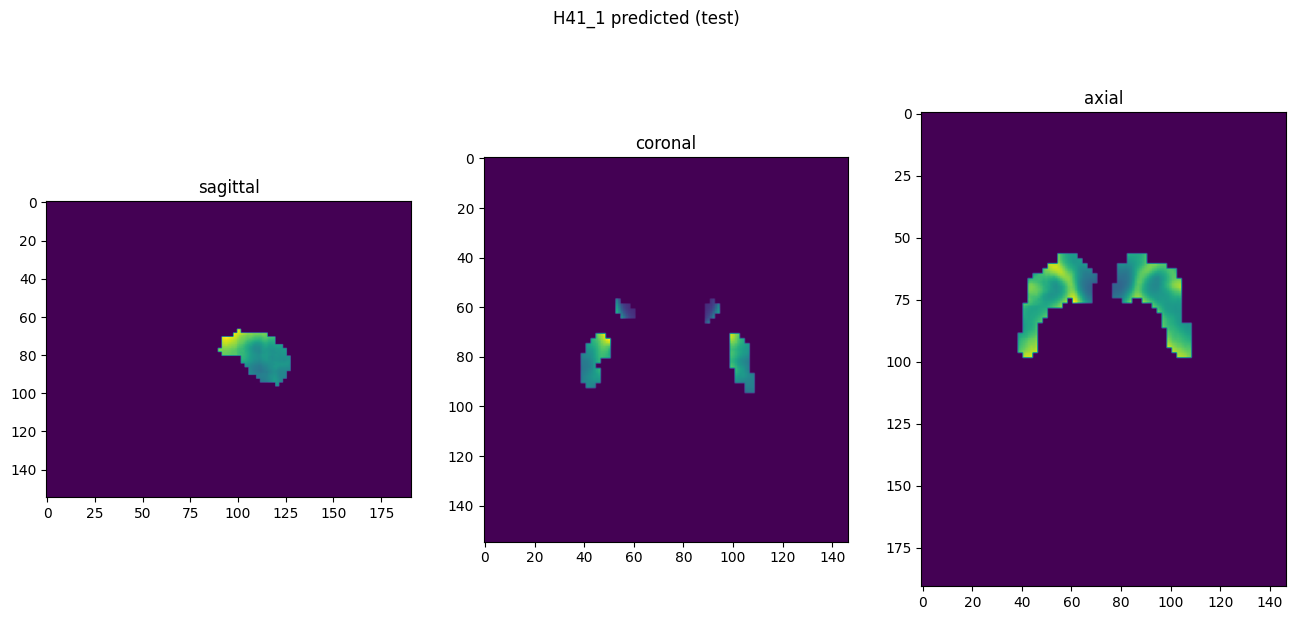

In [10]:
showResults(model, gen, threshold=None, background=False)